In [1]:
import japanize_matplotlib

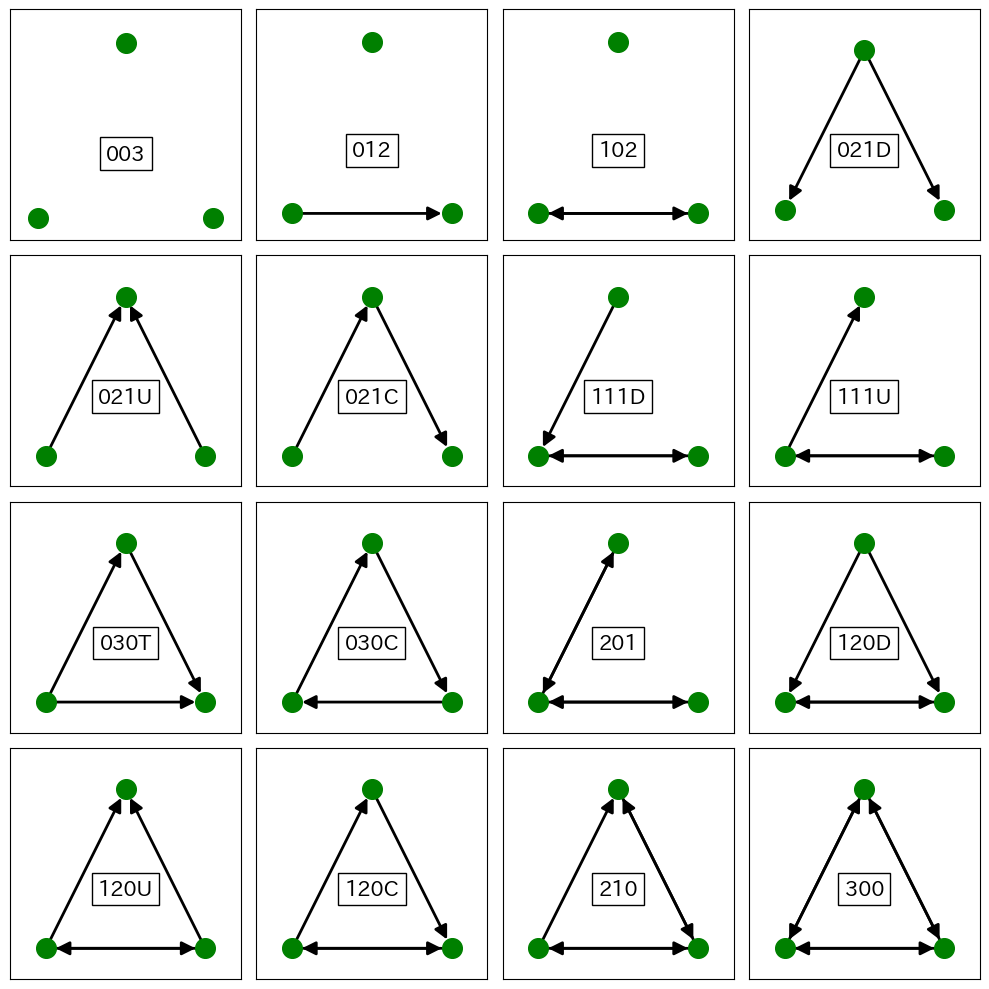

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
triads = {
    "003": [],
    "012": [(1, 2)],
    "102": [(1, 2), (2, 1)],
    "021D": [(3, 1), (3, 2)],
    "021U": [(1, 3), (2, 3)],
    "021C": [(1, 3), (3, 2)],
    "111D": [(1, 2), (2, 1), (3, 1)],
    "111U": [(1, 2), (2, 1), (1, 3)],
    "030T": [(1, 2), (3, 2), (1, 3)],
    "030C": [(1, 3), (3, 2), (2, 1)],
    "201": [(1, 2), (2, 1), (3, 1), (1, 3)],
    "120D": [(1, 2), (2, 1), (3, 1), (3, 2)],
    "120U": [(1, 2), (2, 1), (1, 3), (2, 3)],
    "120C": [(1, 2), (2, 1), (1, 3), (3, 2)],
    "210": [(1, 2), (2, 1), (1, 3), (3, 2), (2, 3)],
    "300": [(1, 2), (2, 1), (2, 3), (3, 2), (1, 3), (3, 1)],
}

for (title, triad), ax in zip(triads.items(), axes.flatten()):
    G = nx.DiGraph()
    G.add_nodes_from([1, 2, 3])
    G.add_edges_from(triad)
    nx.draw_networkx(
        G,
        ax=ax,
        with_labels=False,
        node_color=["green"],
        node_size=200,
        arrowsize=20,
        width=2,
        pos=nx.planar_layout(G),
    )
    ax.set_xlim(val * 1.2 for val in ax.get_xlim())
    ax.set_ylim(val * 1.2 for val in ax.get_ylim())
    ax.text(
        0,
        0,
        title,
        fontsize=15,
        fontweight="extra bold",
        horizontalalignment="center",
        bbox={"boxstyle": "square,pad=0.3", "fc": "none"},
    )
fig.tight_layout()
plt.show()

In [9]:
import gzip
from string import ascii_lowercase as lowercase

import matplotlib.pyplot as plt
import networkx as nx


def generate_graph(words):
    G = nx.Graph(name="words")
    lookup = {c: lowercase.index(c) for c in lowercase}

    def edit_distance_one(word):
        for i in range(len(word)):
            left, c, right = word[0:i], word[i], word[i + 1 :]
            j = lookup[c]  # lowercase.index(c)
            for cc in lowercase[j + 1 :]:
                yield left + cc + right

    candgen = (
        (word, cand)
        for word in sorted(words)
        for cand in edit_distance_one(word)
        if cand in words
    )
    G.add_nodes_from(words)
    for word, cand in candgen:
        G.add_edge(word, cand)
    return G


def words_graph():
    """Return the words example graph from the Stanford GraphBase"""
    fh = gzip.open("words_dat.txt.gz", "r")
    words = set()
    for line in fh.readlines():
        line = line.decode()
        if line.startswith("*"):
            continue
        w = str(line[0:5])
        words.add(w)
    return generate_graph(words)


G = words_graph()
print("Loaded words_dat.txt containing 5757 five-letter English words.")
print("Two words are connected if they differ in one letter.")
print(G)
print(f"{nx.number_connected_components(G)} connected components")

for source, target in [("chaos", "order"), ("nodes", "graph"), ("pound", "marks")]:
    print(f"Shortest path between {source} and {target} is")
    try:
        shortest_path = nx.shortest_path(G, source, target)
        for n in shortest_path:
            print(n)
    except nx.NetworkXNoPath:
        print("None")


# draw a subset of the graph
boundary = list(nx.node_boundary(G, shortest_path))
G.add_nodes_from(shortest_path, color="red")
G.add_nodes_from(boundary, color="blue")
H = G.subgraph(shortest_path + boundary)
colors = nx.get_node_attributes(H, "color")
options = {"node_size": 1500, "alpha": 0.3, "node_color": colors.values()}
pos = nx.kamada_kawai_layout(H)
nx.draw(H, pos, **options)
nx.draw_networkx_labels(H, pos, font_weight="bold")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'words_dat.txt.gz'

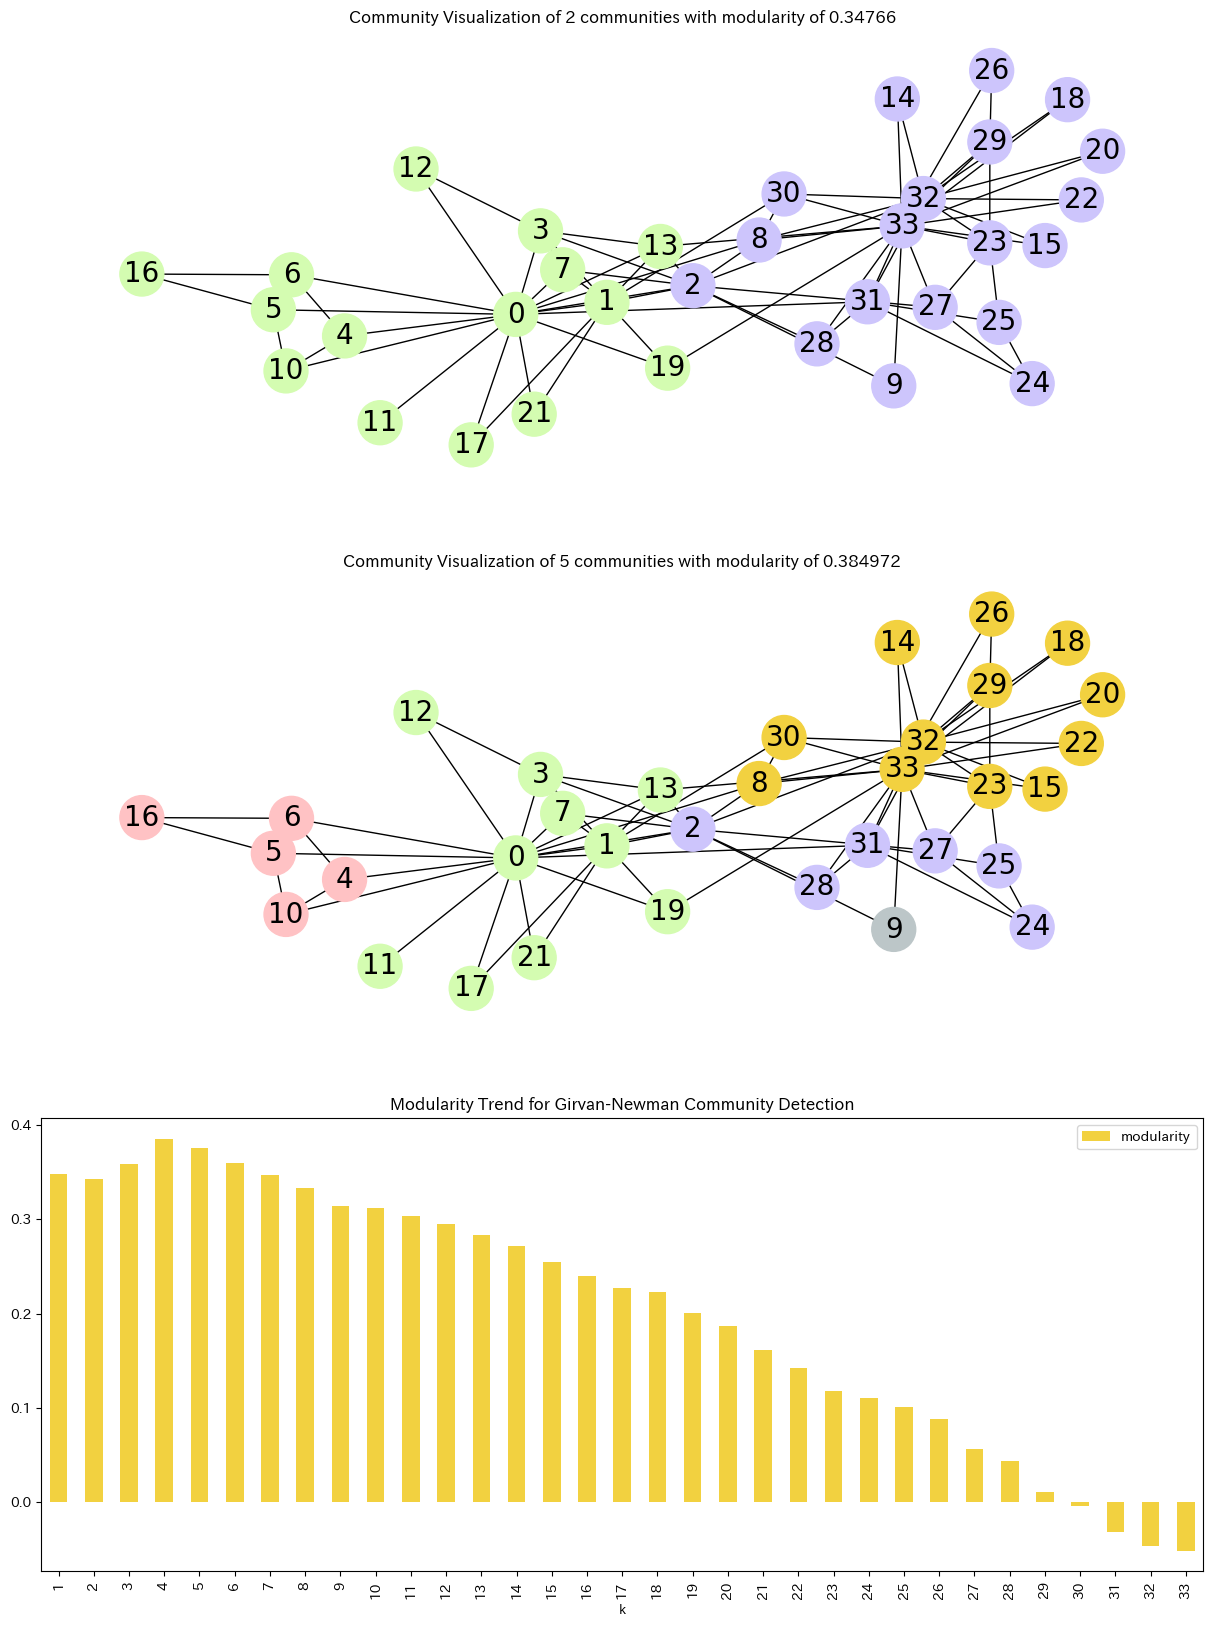

In [6]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Load karate graph and find communities using Girvan-Newman
G = nx.karate_club_graph()
communities = list(nx.community.girvan_newman(G))

# Modularity -> measures the strength of division of a network into modules
modularity_df = pd.DataFrame(
    [
        [k + 1, nx.community.modularity(G, communities[k])]
        for k in range(len(communities))
    ],
    columns=["k", "modularity"],
)


# function to create node colour list
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "#BCC6C8"][:number_of_colors]
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors


# function to plot graph with node colouring based on communities
def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx.community.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    plt.subplot(3, 1, i)
    plt.title(title)
    nx.draw(
        graph,
        pos=pos,
        node_size=1000,
        node_color=node_colors,
        with_labels=True,
        font_size=20,
        font_color="black",
    )


fig, ax = plt.subplots(3, figsize=(15, 20))

# Plot graph with colouring based on communities
visualize_communities(G, communities[0], 1)
visualize_communities(G, communities[3], 2)

# Plot change in modularity as the important edges are removed
modularity_df.plot.bar(
    x="k",
    ax=ax[2],
    color="#F2D140",
    title="Modularity Trend for Girvan-Newman Community Detection",
)
plt.show()


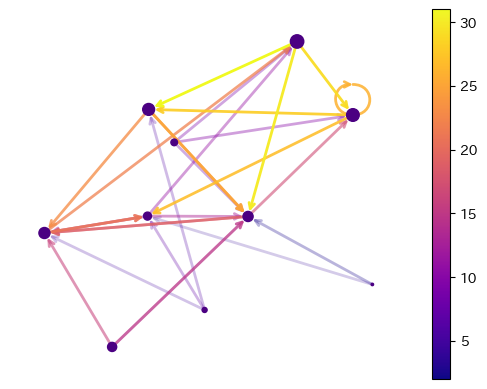

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

seed = 13648  # Seed random number generators for reproducibility
G = nx.random_k_out_graph(10, 3, 0.5, seed=seed)
pos = nx.spring_layout(G, seed=seed)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)

ax = plt.gca()
ax.set_axis_off()
plt.colorbar(pc, ax=ax)
plt.show()

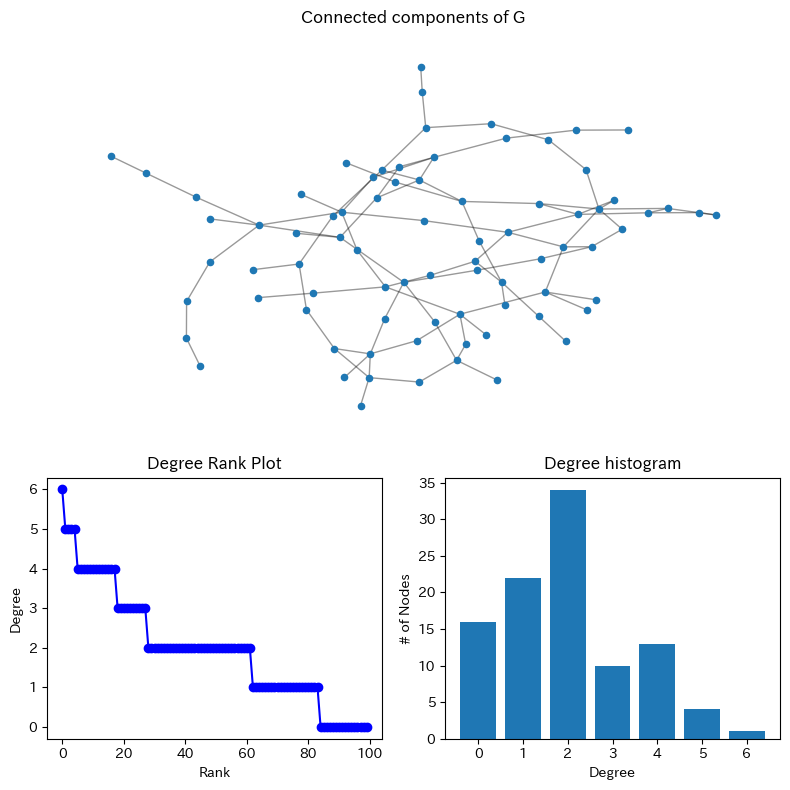

In [5]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

G = nx.gnp_random_graph(100, 0.02, seed=10374196)

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()


In [4]:
from random import sample
import networkx as nx
import matplotlib.pyplot as plt

# Gold standard data of positive gene functional associations
# from https://www.inetbio.org/wormnet/downloadnetwork.php
G = nx.read_edgelist("WormNet.v3.benchmark.txt")

# remove randomly selected nodes (to make example fast)
num_to_remove = int(len(G) / 1.5)
nodes = sample(list(G.nodes), num_to_remove)
G.remove_nodes_from(nodes)

# remove low-degree nodes
low_degree = [n for n, d in G.degree() if d < 10]
G.remove_nodes_from(low_degree)

# largest connected component
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

# compute centrality
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

# compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("Gene functional association network (C. elegans)", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "node color = community structure",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.06,
    "node size = betweenness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'WormNet.v3.benchmark.txt'

c:\Users\tmina\Google ドライブ\github\sandbox\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32076 (\N{CJK UNIFIED IDEOGRAPH-7D4C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tmina\Google ドライブ\github\sandbox\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21942 (\N{CJK UNIFIED IDEOGRAPH-55B6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tmina\Google ドライブ\github\sandbox\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tmina\Google ドライブ\github\sandbox\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12505 (\N{KATAKANA LETTER BE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tmina\Google ドライブ\github\sandbox\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarnin

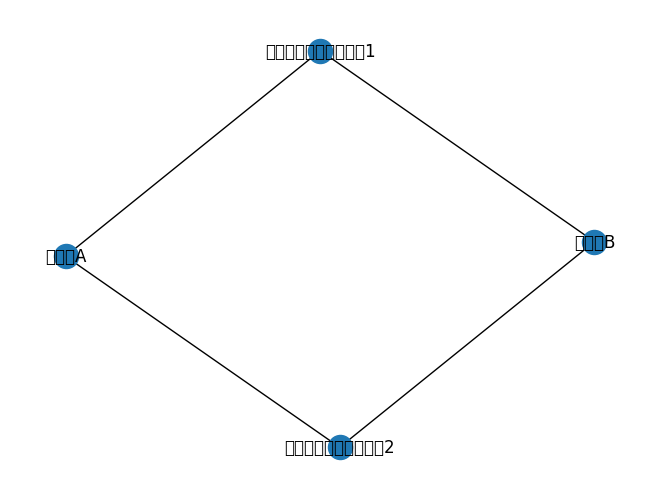

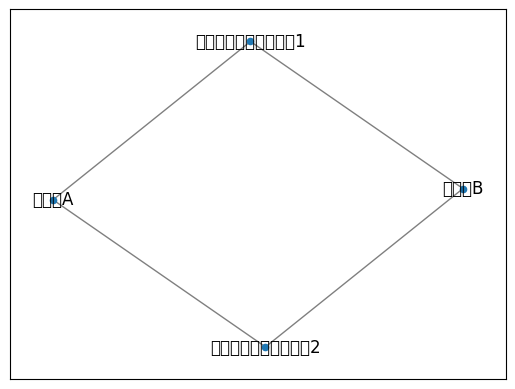

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain

# ネットワークの作成
G = nx.Graph()

# ノード（経営者や企業）の追加
G.add_node("経営者A")
G.add_node("経営者B")
G.add_node("ベンチャーキャピタル1")
G.add_node("ベンチャーキャピタル2")

# エッジ（関係性）の追加
G.add_edge("経営者A", "ベンチャーキャピタル1")
G.add_edge("経営者B", "ベンチャーキャピタル1")
G.add_edge("経営者A", "ベンチャーキャピタル2")
G.add_edge("経営者B", "ベンチャーキャピタル2")

# ネットワークの可視化
pos = nx.spring_layout(G)  # ノードの位置を決定
nx.draw(G, pos, with_labels=True)
plt.show()

# コミュニティ検出
partition = community_louvain.best_partition(G)

# コミュニティごとにネットワークを可視化
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size=20)

nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos)
plt.show()


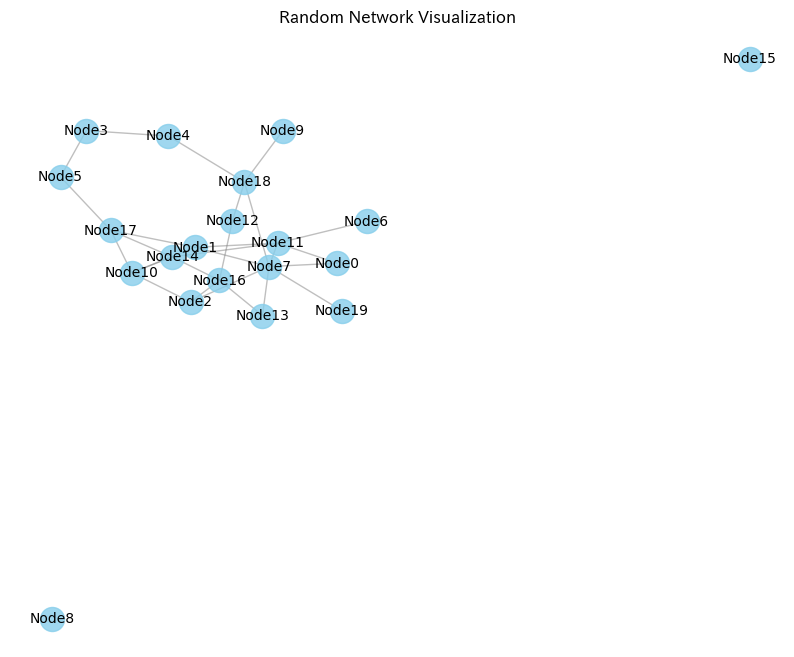

Basic Network Information:
Number of nodes: 20
Number of edges: 27


NetworkXError: Found infinite path length because the graph is not connected

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# ネットワークの作成
G = nx.Graph()

# ノードの追加
num_nodes = 20
for i in range(num_nodes):
    G.add_node(f"Node{i}")

# ランダムなエッジの追加
num_edges = 30
for _ in range(num_edges):
    node1 = random.choice(list(G.nodes()))
    node2 = random.choice(list(G.nodes()))
    if node1 != node2 and not G.has_edge(node1, node2):
        G.add_edge(node1, node2)

# ネットワークの可視化
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color="skyblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
plt.title("Random Network Visualization")
plt.axis("off")
plt.show()

# ネットワークの基本的な情報
print("Basic Network Information:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# ネットワークの直径
diameter = nx.diameter(G)
print(f"Diameter of the network: {diameter}")

# クラスタ係数
avg_clustering_coefficient = nx.average_clustering(G)
print(f"Average clustering coefficient: {avg_clustering_coefficient}")

# コミュニティ検出
communities = list(nx.community.greedy_modularity_communities(G))
print("\nDetected Communities:")
for idx, community in enumerate(communities):
    print(f"Community {idx + 1}: {community}")

# 重要人物の判定（次数中心性を使用）
degree_centrality = nx.degree_centrality(G)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nSorted Degree Centrality:")
for node, centrality in sorted_degree:
    print(f"{node}: {centrality}")

# 他の中心性指標の計算
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# ノードの中心性指標の出力
print("\nNode Centrality Measures:")
for node in G.nodes():
    print(f"Node: {node}")
    print(f"  Degree Centrality: {degree_centrality[node]}")
    print(f"  Closeness Centrality: {closeness_centrality[node]}")
    print(f"  Betweenness Centrality: {betweenness_centrality[node]}")
    print(f"  Eigenvector Centrality: {eigenvector_centrality[node]}")
    print()
